In [1]:
pip install torch torchtext

Note: you may need to restart the kernel to use updated packages.


### Resources used: 
* https://peterbloem.nl/blog/transformers

# Notes on this implementation:
* I used simple approach, with smaller model (hidden_dim=100, seq_len=10, num_heads=4)
* Here during inference I use greedy decoding. For further work, some top_p, top_k, beam_search can be implemented
* Task is simple -> digit sorter

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.nn import functional as F
import numpy as np

from typing import Optional, Union, List

In [3]:
q = torch.randn((32, 10, 100))
k = torch.randn((32, 10, 100))
v = torch.randn((32, 10, 100))

scores = q @ k.transpose(2, 1)/q.shape[-1]
scores = scores.masked_fill(my_mask.squeeze()==0, -1e9)
probs = 

### Input, masks & Embeddings

In [56]:
class PositionalEncoding(nn.Module):
    
    def __init__(self,
                 hidden_size:int=100,
                 seq_len: int=10,
                 device: str='cpu'):
        super().__init__()

        self.encoding = torch.zeros(seq_len, hidden_size)
        self.encoding.requires_grad = False  

        pos = torch.arange(0, seq_len)
        pos = pos.float().unsqueeze(dim=1)

        _2i = torch.arange(0, hidden_size, step=2).float()
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / hidden_size)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / hidden_size)))
        self.encoding = self.encoding.to(device)

    def forward(self, x):
        batch_size, seq_len = x.size()

        return self.encoding[:seq_len, :].expand(batch_size, -1, -1)
    
class EmbeddingLayer(nn.Module):
    def __init__(self,
                 hidden_size: int=100,
                 seq_len: int=10,
                 vocab_size: int=10,
                 dropout: float=0.0,
                 device: str='cpu'):
        super().__init__()
        self.pos_emb = PositionalEncoding(hidden_size, seq_len, device)
        self.token_emb = nn.Embedding(vocab_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        return self.dropout(self.pos_emb(x) + self.token_emb(x))

In [5]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

### Multihead Self Attention 

In [6]:
from typing import Callable, Optional
def attention_fn(q: torch.Tensor,
                 k: torch.Tensor,
                 v: torch.Tensor,
                 mask: Optional[torch.Tensor]=None,
                 dropout: Optional[torch.nn.Module]=None,
                 return_attn_probs: bool=False):
    
    assert q.dim() == 3, "expected to have 3 dims in shapes"
    assert q.shape == k.shape == v.shape, "shapes are different"
    
    dk = torch.tensor(q.shape[-1])
    attn_output = None
    
    # Calculate scaled dot product with mask
    scaled_dot_product = q @ k.transpose(2, 1) / torch.sqrt(dk) #assuming, that q, k, v have shape (bs, N, hidden_dim)
    if mask is not None:
        scaled_dot_product = scaled_dot_product.masked_fill(mask==0, -1e9)
    
    # Calculate softmax and apply dropout if passed as a module
    attn_probs = F.softmax(scaled_dot_product, dim=-1)    
    if dropout:
        attn_probs = dropout(attn_probs)
    
    attn_output = attn_probs @ v 
    
    if return_attn_probs == True:
        return attn_output, attn_probs
    else:
        return attn_output, None
    
    

In [57]:
class MultiheadSelfAttention(nn.Module):
    def __init__(self,
                 hidden_dim: int=100,
                 num_heads: int=4, 
                 dropout: Optional[float]=None, #attn dropout
                 ):
        super().__init__()
        assert hidden_dim % num_heads == 0  
        self.hidden_dim = hidden_dim 
        self.num_heads = num_heads
        
        self.tokeys = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.tovalues = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.toqueries = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        self.wo = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        self.attn_output = None
        self.dropout = None
        if dropout is not None:
            self.dropout = nn.Dropout(p=dropout)
        
    def forward(self,
                q: torch.Tensor,
                k: torch.Tensor,
                v: torch.Tensor,
                mask: Optional[torch.Tensor]=None,
                return_attn_probs: bool=False
                ):
        
        assert q.size() == k.size() == v.size()
        if mask is not None:
            assert mask.shape[-1] == q.shape[-2]                    #size mask == input_shape of q/k/v
        
        b_size, n, hidden_dim = q.size()
        
        assert hidden_dim % self.num_heads == 0
        head_hidden_dim = hidden_dim // self.num_heads
        num_heads = self.num_heads
        
        queries = self.toqueries(q)
        keys = self.tokeys(k)
        values = self.tovalues(v)
        
        # to have shape = (b_size, num_heads, head_hidden_dim, n), to then fold heads into batchsizes 
        queries = queries.view(b_size, n, num_heads, head_hidden_dim).transpose(1, 2).contiguous() 
        keys    = keys   .view(b_size, n, num_heads, head_hidden_dim).transpose(1, 2).contiguous() 
        values  = values .view(b_size, n, num_heads, head_hidden_dim).transpose(1, 2).contiguous()
        
        queries = queries.view(b_size * num_heads, n, head_hidden_dim)
        keys    = keys   .view(b_size * num_heads, n, head_hidden_dim)
        values  = values .view(b_size * num_heads, n, head_hidden_dim)
        
        attn_output, attn_probs = attention_fn(q=queries,
                                   k=keys,
                                   v=values,
                                   mask=mask,
                                   dropout=self.dropout,
                                   return_attn_probs=return_attn_probs)
        
        attn_output = attn_output.view(b_size, num_heads, n, head_hidden_dim)
        attn_output = attn_output.transpose(1, 2).contiguous().view(b_size, n, head_hidden_dim * num_heads)
        attn_output = self.wo(attn_output)
        if return_attn_probs:
            attn_probs = attn_probs.view(b_size, num_heads, n, n)
            attn_probs = attn_probs.transpose(1, 2).contiguous().view(b_size, n, n * num_heads)
        
        return attn_output, attn_probs
        

In [58]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hidden_dim: int=100,
                 num_heads: int=4,
                 attn_dropout: float=0.0,
                 mlp_dropout: float=0.0,
                 mlp_scale: int=4,):
    
        super().__init__()
        self.mha = MultiheadSelfAttention(hidden_dim=hidden_dim,
                                          num_heads=num_heads,
                                          dropout=attn_dropout,)
        self.mlp = nn.Sequential(nn.Linear(in_features=hidden_dim,
                                           out_features=mlp_scale * hidden_dim,),
                                 nn.ReLU(),
                                 nn.Dropout(p=mlp_dropout),
                                 nn.Linear(in_features=hidden_dim * mlp_scale,
                                           out_features=hidden_dim))
        
        self.layernorm_layers = nn.ModuleList([nn.LayerNorm(normalized_shape=hidden_dim),
                                 nn.LayerNorm(normalized_shape=hidden_dim)])
        
    def forward(self,
                x: torch.Tensor,
                src_mask: Optional[torch.Tensor]=None)->torch.Tensor:
        x = self.layernorm_layers[0](self.mha(x, x, x, mask=src_mask)[0] + x)
        x = self.layernorm_layers[1](self.mlp(x) + x)
        return x
        
        
class EncoderBlock(nn.Module):
    def __init__(self,
                 num_layers: int=4,
                 hidden_dim: int=100,
                 num_heads: int=4,
                 attn_dropout: float=0.0,
                 mlp_dropout: float=0.0,
                 mlp_scale: int=4,):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(hidden_dim,
                                                  num_heads,
                                                  attn_dropout,
                                                  mlp_dropout,
                                                  mlp_scale) for _ in range(num_layers)])
    def forward(self, 
                x: torch.Tensor,
                src_mask: Optional[torch.Tensor]=None) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, src_mask)
            
        return x

In [9]:
encoder = EncoderBlock()
test_sample = torch.randn(32, 10, 100)

summary(encoder,
        input_data=test_sample,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
EncoderBlock (EncoderBlock)                   [32, 10, 100]        [32, 10, 100]        --                   True
├─ModuleList (layers)                         --                   --                   --                   True
│    └─EncoderLayer (0)                       [32, 10, 100]        [32, 10, 100]        --                   True
│    │    └─MultiheadSelfAttention (mha)      [32, 10, 100]        [32, 10, 100]        40,400               True
│    │    └─ModuleList (layernorm_layers)     --                   --                   (recursive)          True
│    │    └─Sequential (mlp)                  [32, 10, 100]        [32, 10, 100]        80,500               True
│    │    └─ModuleList (layernorm_layers)     --                   --                   (recursive)          True
│    └─EncoderLayer (1)                       [32, 10, 100]        [32, 10, 100]   

In [59]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hidden_dim: int=100,
                 num_heads: int=4,
                 attn_dropout: float=0.0,
                 mlp_dropout: float=0.0,
                 mlp_scale: int=4):
        super().__init__()
        self.masked_mha = MultiheadSelfAttention(hidden_dim=hidden_dim,
                                                 num_heads=num_heads,
                                                 dropout=attn_dropout)
        self.enc_dec_mha = MultiheadSelfAttention(hidden_dim=hidden_dim,
                                                 num_heads=num_heads,
                                                 dropout=attn_dropout)
        self.mlp = nn.Sequential(nn.Linear(hidden_dim, hidden_dim * mlp_scale),
                                 nn.ReLU(),
                                 nn.Dropout(mlp_dropout),
                                 nn.Linear(hidden_dim * mlp_scale, hidden_dim))
        self.layernorm_layers = nn.ModuleList([nn.LayerNorm(normalized_shape=hidden_dim) for _ in range(3)])
        
    def forward(self,
                x_dec: torch.Tensor,
                x_enc: torch.Tensor,
                trg_mask: Optional[torch.Tensor],
                src_mask: Optional[torch.Tensor]=None)->torch.Tensor:
        x = self.layernorm_layers[0](self.masked_mha(x_dec, x_dec, x_dec, mask=trg_mask)[0] + x_dec)
        x = self.layernorm_layers[1](self.enc_dec_mha(x_enc, x_enc, x_dec, mask=src_mask)[0] + x_dec)
        x = self.layernorm_layers[2](self.mlp(x) + x)
        
        return x
    
    
class DecoderBlock(nn.Module):
    def __init__(self,
                 num_layers: int=4,
                 hidden_dim: int=100,
                 num_heads: int=4,
                 attn_dropout: float=0.0,
                 mlp_dropout: float=0.0,
                 mlp_scale: int=4):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderLayer(hidden_dim=hidden_dim,
                         num_heads=num_heads,
                         attn_dropout=attn_dropout,
                         mlp_dropout=mlp_dropout,
                         mlp_scale=mlp_scale)
            for _ in range(num_layers)
        ])
        
    def forward(self,
                x_dec: torch.Tensor,
                x_enc: torch.Tensor,
                trg_mask: Optional[torch.Tensor]=None,
                src_mask: Optional[torch.Tensor]=None,)-> torch.Tensor:
        for layer in self.layers:
            x = layer(x_dec, x_enc, trg_mask, src_mask)
        return x

### Transformer itself

In [74]:
class Transformer(nn.Module):
    def __init__(self,
                 num_layers: int=4,
                 hidden_dim: int=100,
                 num_heads: int=4,
                 attn_dropout: float=0.0,
                 mlp_dropout: float=0.0,
                 mlp_scale: int=4,
                 seq_len: int=10,
                 vocab_size: int=10,
                 emb_dropout: float=0.0,
                 device: str='cpu'
                ):
        super().__init__()
        self.emb = EmbeddingLayer(hidden_dim, seq_len, vocab_size, emb_dropout, device)
        self.encoder = EncoderBlock(num_layers, hidden_dim, num_heads, attn_dropout, mlp_dropout, mlp_scale)
        self.decoder = DecoderBlock(num_layers, hidden_dim, num_heads, attn_dropout, mlp_dropout, mlp_scale)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self,
                src: torch.Tensor,
                tgt: torch.Tensor,
                src_mask: torch.Tensor,
                tgt_mask: torch.Tensor) -> torch.Tensor:
        src = self.emb(src)
        tgt = self.emb(tgt)

        encoder_output = self.encoder(src, src_mask)
        decoder_output = self.decoder(tgt, encoder_output, tgt_mask, src_mask)
        
        return self.linear(decoder_output)

### Test sample

In [12]:
tgt_mask = subsequent_mask(10)
src_mask = torch.ones(1, 10, 10)
source = torch.arange(0, 10).unsqueeze(0)
target = torch.arange(9, -1, step=-1).unsqueeze(0)

test_sample = (source, target, src_mask, tgt_mask)
transformer = Transformer()

In [13]:
summary(transformer,
        input_data=test_sample,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
Transformer (Transformer)                                    [1, 10]              [1, 10, 4]           --                   True
├─EmbeddingLayer (emb)                                       [1, 10]              [1, 10, 100]         --                   True
│    └─PositionalEncoding (pos_emb)                          [1, 10]              [1, 10, 100]         --                   --
│    └─Embedding (token_emb)                                 [1, 10]              [1, 10, 100]         1,000                True
│    └─Dropout (dropout)                                     [1, 10, 100]         [1, 10, 100]         --                   --
├─EmbeddingLayer (emb)                                       [1, 10]              [1, 10, 100]         (recursive)          True
│    └─PositionalEncoding (pos_emb)                          [1, 10]              [1, 10, 100]  

In [14]:
transformer(source, target, src_mask, tgt_mask).shape

torch.Size([1, 10, 4])

# Digit inverter
* Given list of digits from range(0-9), we want to sort them in descending order

### Data Generation and workings

In [15]:
### I dont need tokenizer here
X_train = torch.randint(high=9,size=(5000, 10))
y_train = torch.sort(X_train, dim=-1, descending=True).values

X_test = torch.randint(high=9, size=(1000, 10))
y_test = torch.sort(X_test, dim=-1, descending=True).values

In [17]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, 
                 source: torch.Tensor,
                 target: torch.Tensor):
        self.source = source
        self.target = target
        
    def __len__(self,):
        return len(self.source)
    
    def __getitem__(self, idx):
        source = self.source[idx]
        target = self.target[idx]
        return source, target
    
# some simple "tokenizer" to have items as an input, and returns masks with tokens_id
# (in this case i dont need tokens_id's since im using integers as input)    
def tiktokenizer(batch: torch.utils.data.DataLoader,
                 seq_len: int=10,
                 device: str='cpu') -> torch.Tensor:
    source = batch[0].to(device)
    target = batch[1].to(device)
    
    batch_size = len(source)
    
    source_mask = torch.ones(1, seq_len, seq_len).to(device)
    tgt_mask = subsequent_mask(seq_len).to(device)
    
    outputs = {'source': source,
               'target': target,
               'src_mask': source_mask,
               'tgt_mask': tgt_mask}
    return outputs

In [61]:
train_dataset = Dataset(source=X_train, target=y_train)
test_dataset = Dataset(source=X_test, target=y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, )
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Training loop and stuff

In [141]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Transformer(device=device).to(device) #with basic params

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [142]:
def train_one_epoch(epoch,
                    model, 
                    train_dataloader,
                    loss_fn,
                    optimizer,
                    device):
    model.train()
    train_loss = 0
    for batch_num, batch in enumerate(train_dataloader):
        inputs = tiktokenizer(batch,
                              seq_len=10,
                              device=device)

        outputs = model(src=inputs['source'],
                        tgt=inputs['target'],
                        src_mask=inputs['src_mask'],
                        tgt_mask=inputs['tgt_mask'])
        
        optimizer.zero_grad()
        loss = loss_fn(outputs, inputs['target'])
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= batch_num 
    
    print(f'Epoch: {epoch} Train loss: {train_loss}')
    return train_loss
    
    
def valid_one_epoch(epoch,
                    model: torch.nn.Module,
                    test_dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    device):
    model.eval()
    with torch.no_grad():
        eval_loss = 0
        for batch_num, batch in enumerate(test_dataloader):
            inputs = tiktokenizer(batch,
                                  seq_len=10,
                                  device=device)

            outputs = model(src=inputs['source'],
                            tgt=inputs['target'],
                            src_mask=inputs['src_mask'],
                            tgt_mask=inputs['tgt_mask'])

            loss = loss_fn(outputs, inputs['target'])
            
            eval_loss += loss.item()
        
        eval_loss /= batch_num
        print(f'Epoch: {epoch} Test loss: {eval_loss}')
        return eval_loss    

In [143]:
from tqdm.auto import tqdm
history = {'train_loss':[],
           'val_loss': []}
num_epochs = 50

for epoch in tqdm(range(num_epochs)):
    history['train_loss'].append(train_one_epoch(epoch, model, train_dataloader, loss, optimizer, device))
    history['val_loss'].append(valid_one_epoch(epoch, model, test_dataloader, loss, device))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Train loss: 0.8372713461136206
Epoch: 0 Test loss: 0.594544582789944
Epoch: 1 Train loss: 0.37167139895833456
Epoch: 1 Test loss: 0.23044885839185408
Epoch: 2 Train loss: 0.14090958650773153
Epoch: 2 Test loss: 0.13332620431338588
Epoch: 3 Train loss: 0.08700349246366666
Epoch: 3 Test loss: 0.19044269957850057
Epoch: 4 Train loss: 0.07409162669538115
Epoch: 4 Test loss: 0.032013756343193596
Epoch: 5 Train loss: 0.050700599050077684
Epoch: 5 Test loss: 0.05569267837751296
Epoch: 6 Train loss: 0.03469393156074847
Epoch: 6 Test loss: 0.052735235061376326
Epoch: 7 Train loss: 0.04246111947129695
Epoch: 7 Test loss: 0.08533437069385283
Epoch: 8 Train loss: 0.04411906387674837
Epoch: 8 Test loss: 0.04830003860256364
Epoch: 9 Train loss: 0.013592714396788953
Epoch: 9 Test loss: 0.03129395333329035
Epoch: 10 Train loss: 0.05707979446500152
Epoch: 10 Test loss: 0.016446957567466364
Epoch: 11 Train loss: 0.02464760314577665
Epoch: 11 Test loss: 0.007450633669166916
Epoch: 12 Train loss:

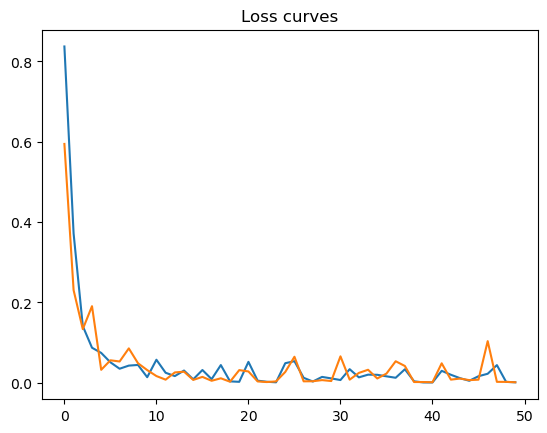

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.plot(range(num_epochs), history['train_loss'], label='Train')
plt.plot(range(num_epochs), history['val_loss'], label='Val')

plt.title('Loss curves')

plt.show()

In [153]:
# Inference check
model.eval()
batch = next(iter(test_dataloader))
with torch.no_grad():
    inputs = tiktokenizer(batch,
                          seq_len=10,
                          device=device)

    outputs = model(src=inputs['source'],
                    tgt=inputs['target'],
                    src_mask=inputs['src_mask'],
                    tgt_mask=inputs['tgt_mask'])
    

In [159]:
# Real source-target
batch[0][0], batch[1][0]

(tensor([2, 4, 2, 2, 8, 2, 6, 7, 7, 0]),
 tensor([8, 7, 7, 6, 4, 2, 2, 2, 2, 0]))

In [167]:
# Model output
torch.argmax(outputs, dim=1)[0]

tensor([8, 7, 7, 6, 4, 2, 2, 2, 2, 0], device='cuda:0')